<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/TFT_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pytorch_forecasting
!pip install -q statsmodels --upgrade
!pip install -q yfinance
!pip install -q tensorboard
!pip install -q tensorboardX
!pip install -q gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.1 MB/s eta 

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


            ETH-USD_Volume  ETH-USD_Open  BTC-USD_Volume  BTC-USD_Open  \
2013-02-04    0.000000e+00      0.000000    0.000000e+00      0.000000   
2013-02-05    0.000000e+00      0.000000    0.000000e+00      0.000000   
2013-02-06    0.000000e+00      0.000000    0.000000e+00      0.000000   
2013-02-07    0.000000e+00      0.000000    0.000000e+00      0.000000   
2013-02-08    0.000000e+00      0.000000    0.000000e+00      0.000000   
...                    ...           ...             ...           ...   
2023-01-30    9.180418e+09   1646.147705    2.720560e+10  23774.648438   
2023-01-31    6.585191e+09   1567.419922    2.283783e+10  22840.796875   
2023-02-01    8.116969e+09   1586.488159    2.668326e+10  23137.835938   
2023-02-02    1.055808e+10   1641.365967    3.206694e+10  23720.824219   
2023-02-03    9.808874e+09   1647.252563    3.061216e+10  23550.281250   

            ^DJI_Volume     ^DJI_Open  ^GSPC_Volume   ^GSPC_Open  \
2013-02-04    130420000  14009.790039    33

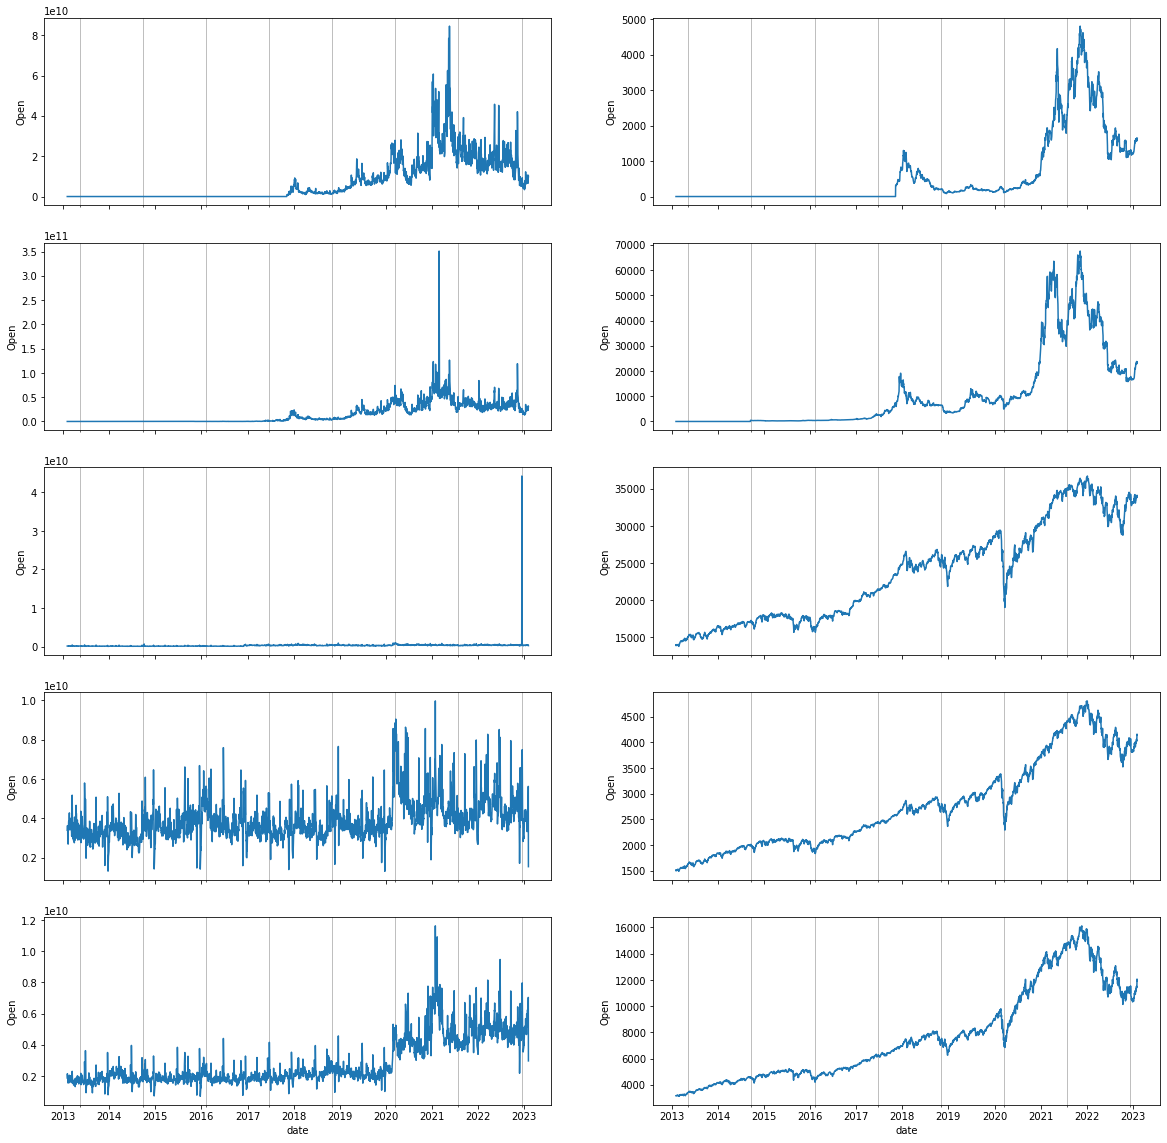

In [4]:
import yfinance as yahooFinance
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

stocks1 = ["AAPL", '^IXIC', '^GSPC', '^DJI','MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA']
stocks = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA',
          'WMT', 'TSLA', 'PG', 'META', 'MA', 'CVX', 'LLY', 'HD', 'ABBV', 'MRK', 'BAC', 'KO', 
          'PFE', 'PEP', 'AVGO', 'ORCL', 'TMO', 'COST', 'CSCO', 'ABT', 'MCD', 'NKE', 'DHR', 
          'TMUS', 'ACN', 'DIS', 'VZ', 'NEE', 'CMCSA', 'WFC', 'TXN', 'LIN', 'PM', 'UPS', 'ADBE', 
          'BMY', 'SCHW', 'MS', 'CRM', 'COP', 'RTX', 'AMGN', 'NFLX', 'HON', 'T', 'UNP', 'QCOM', 
          'IBM', 'DE', 'CAT', 'LOW', 'BA', 'SBUX', 'INTC', 'SPGI', 'LMT', 'GS', 'CVS', 'BLK', 
          'AXP', 'ELV', 'AMD', 'GILD', 'INTU', 'PLD', 'MDT', 'AMT', 'ADP', 'SYK', 'ISRG', 
          'TJX', 'EL', 'C', 'CB', 'CI', 'MDLZ', 'AMAT', 'PYPL', 'ADI', 'BKNG', 'MMC', 'MO', 'GE', 
          'DUK', 'SLB', 'SO', 'PGR', 'NOW', 'NOC', 'VRTX', 'EOG', 'REGN', 'ZTS', 'TGT', 'MRNA', 'BDX', 
          'MMM', 'HCA', 'USB', 'ITW', 'APD', 'CSX', 'GD', 'PNC', 'BSX', 'CL', 'WM', 'EQIX', 'FISV', 'FCX', 
          'CME', 'ETN', 'CCI', 'AON', 'SHW', 'LRCX', 'MU', 'TFC', 'HUM', 'ATVI', 'ICE', 'KLAC', 'NSC', 
          'CHTR', 'OXY', 'EMR', 'MET', 'PXD', 'MPC', 'MCO', 'MCK', 'DG', 'GM', 'MNST', 'KHC', 'ORLY', 
          'D', 'VLO', 'SNPS', 'SRE', 'F', 'KDP', 'AEP', 'GIS', 'PSA', 'MAR', 'PSX', 'ROP', 'FDX', 'EW', 
          'ADM', 'APH', 'AIG', 'JCI', 'HSY', 'A', 'KMB', 'AZO', 'CTAS', 'CDNS', 'TRV', 'AFL', 'HES', 'CTVA', 
          'MSI', 'EXC', 'ECL', 'CNC', 'NXPI', 'DXCM', 'PAYX', 'NEM', 'KMI', 'ADSK', 'TT', 'MCHP', 'DVN', 
          'ROST', 'LVS', 'FIS', 'AJG', 'STZ', 'BIIB', 'SYY', 'CMG', 'O', 'RSG', 'IQV', 'PH', 'XEL', 'DOW', 
          'SPG', 'WMB', 'TEL', 'MSCI', 'IDXX', 'BK', 'NUE', 'LHX', 'FTNT', 'COF', 'ALL', 'HAL', 'PRU', 'CARR', 
          'DD', 'TDG', 'YUM', 'ANET', 'HLT', 'PCAR', 'CMI', 'ED', 'ABC', 'EA', 'AMP', 'OTIS', 'WELL', 'MTD', 
          'ODFL', 'SBAC', 'KR', 'AME', 'DLTR', 'VICI', 'DHI', 'ROK', 'WBA', 'KEYS', 'PEG', 'PCG', 'CSGP', 
          'CTSH', 'ENPH', 'RMD', 'OKE', 'WEC', 'BKR', 'NDAQ', 'WBD', 'ILMN', 'PPG', 'GLW', 'STT', 'LYB', 
          'ES', 'IFF', 'DLR', 'AWK', 'VRSK', 'DFS', 'HPQ', 'GWW', 'GPN', 'WTW', 'ON', 'FAST', 'LEN', 'CEG', 
          'APTV', 'TROW', 'URI', 'IT', 'ALB', 'CBRE', 'ZBH', 'EIX', 'MTB', 'CDW', 'ULTA', 'EFX', 'HRL', 'FANG', 
          'TSCO', 'EBAY', 'DAL', 'FE', 'VMC', 'HIG', 'ARE', 'K', 'RJF', 'GPC', 'TSN', 'FITB', 'WY', 'FTV', 
          'ACGL', 'DTE', 'BAX', 'AEE', 'IR', 'AVB', 'FRC', 'MKC', 'VRSN', 'PPL', 'EQR', 'ETR', 'HPE', 'LH', 
          'ANSS', 'LUV', 'PFG', 'MLM', 'HBAN', 'XYL', 'RF', 'CAH', 'WAT', 'CFG', 'STE', 'PWR', 'CHD', 'HOLX', 
          'CTRA', 'NTRS', 'VTR', 'EXR', 'DOV', 'CAG', 'CNP', 'WRB', 'TDY', 'GRMN', 'CMS', 'EPAM', 'STLD', 'BBY', 
          'WST', 'WAB', 'DRI', 'FSLR', 'INVH', 'MPWR', 'AES', 'JBHT', 'ALGN', 'AMCR', 'ROL', 'PAYC', 'MAA', 'IEX', 
          'INCY', 'TTWO', 'BALL', 'OMC', 'CLX', 'DGX', 'CINF', 'EXPD', 'MRO', 'MOH', 'KEY', 'COO', 'BRO', 'TRGP', 
          'SEDG', 'FOX', 'FOXA', 'PKI', 'SJM', 'HWM', 'CPB', 'LYV', 'BR', 'CF', 'FMC', 'J', 'ATO', 'ETSY', 'FDS', 
          'SWKS', 'UAL', 'ZBRA', 'NVR', 'AVY', 'MOS', 'SIVB', 'PTC', 'RCL', 'LKQ', 'MGM', 'SYF', 'TXT', 'TER', 
          'EVRG', 'CPRT', 'BEN', 'IRM', 'VTRS', 'EXPE', 'FLT', 'LW', 'GEN', 'PEAK', 'L', 'KIM', 'APA', 'IPG', 
          'ESS', 'NTAP', 'RE', 'NDSN', 'LNT', 'AKAM', 'LDOS', 'IP', 'TYL', 'TRMB', 'SNA', 'UDR', 'PARA', 'JKHY', 
          'CBOE', 'CE', 'BIO', 'POOL', 'MTCH', 'EQT', 'SWK', 'PKG', 'WDC', 'TFX', 'MKTX', 'CPT', 'DPZ', 'CRL', 'GL', 
          'STX', 'HST', 'VFC', 'MAS', 'NWS', 'NWSA', 'NI', 'PHM', 'CHRW', 'WYNN', 'HSIC', 'CCL', 'EMN', 'KMX', 'REG', 
          'BXP', 'UHS', 'BBWI', 'JNPR', 'TPR', 'BWA', 'AAL', 'ALLE', 'QRVO', 'CZR', 'CDAY', 'WRK', 'AOS', 'AAP', 'HII', 
          'HAS', 'IVZ', 'CMA', 'FFIV', 'CTLT', 'PNW', 'WHR', 'FRT', 'RHI', 'PNR', 'DISH', 'SEE', 'RL', 'ZION', 'OGN', 
          'NRG', 'XRAY', 'MHK', 'DVA', 'SBNY', 'GNRC', 'AIZ', 'DXC', 'NWL', 'ALK', 'NCLH', 'LUMN', 'LNC', 'VNO', 'TECH', 
          'TAP', '^IXIC', '^GSPC', '^DJI', 'BTC-USD', 'ETH-USD']

stocks_ts = pd.DataFrame()
for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period="10y")
    data.index = data.index.date
    d = data.copy()[['Open', 'Volume']]
    stocks_ts.insert(0, stock+"_Open", d['Open'])
    stocks_ts.insert(0, stock+"_Volume", d['Volume'])
    stocks_ts[stock+"_Open"] = stocks_ts[stock+'_Open'].fillna(0)
    stocks_ts[stock+"_Volume"] = stocks_ts[stock+'_Volume'].fillna(0)

stocks_ts.fillna(0)
print(stocks_ts)

# add other indicators
# inflation rate, interest rate, employment

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    stocks_ts[stocks_ts.columns[i]].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Open")   
    axx[i].grid(which='minor', axis='x')

In [5]:
import pandas as pd
infvalues=pd.read_csv("/content/sample_data/Book2.csv")
infvalues=infvalues.drop(["Year", "Annual"], axis=1).values
inf=[]
for i in infvalues:
  inf = inf + list(i)

dti=pd.date_range(start="1948-01-01", end="2023-12-31", freq="M")

inf.reverse()

csvdf=pd.DataFrame(inf)
csvdf.index=dti

dti=pd.date_range(start="1948-01-01", end="2023-12-31", freq="D")
dti.name = 'date'
csvdf=csvdf.reindex(dti, method='nearest')
csvdf.columns = ["Rates"]
print(csvdf.dtypes)
stocks_ts['Inflation'] = csvdf["Rates"]

Rates    float64
dtype: object


In [6]:
import pandas as pd
fedrates=pd.read_csv("/content/sample_data/fed-funds-rate-historical-chart.csv")
fedrates['Datetime'] = pd.to_datetime(fedrates['date'])
fedrates = fedrates.set_index('Datetime')
fedrates = fedrates.drop("date", axis=1)
dti=pd.date_range(start="1955-12-12", end="2023-02-28", freq="D")
fedrates=fedrates.reindex(dti, method='ffill')
fedrates.index = dti
stocks_ts = stocks_ts.assign(InterestRates=fedrates["value"])

In [7]:
import pandas as pd

crudeprices=pd.read_csv("/content/sample_data/crudeoil.csv")
crudeprices['Datetime'] = pd.to_datetime(crudeprices['date'])
crudeprices = crudeprices.set_index('Datetime')

crudeprices.resample('1D').mean().ffill()
crudeprices = crudeprices.drop("date", axis=1)

dti=pd.date_range(start="2010-01-21", end="2023-02-28", freq="D")
crudeprices=crudeprices.reindex(dti, method='ffill')
stocks_ts = stocks_ts.assign(CrudeRates=crudeprices["value"])

In [8]:
import pandas as pd

vix=pd.read_csv("/content/sample_data/vix-volatility-index-historical-chart.csv")
vix['Datetime'] = pd.to_datetime(vix['date'])
vix = vix.set_index('Datetime')

vix.resample('1D').mean().ffill()
vix = vix.drop("date", axis=1)

dti=pd.date_range(start="1990-01-02", end="2023-02-28", freq="D")
vix=vix.reindex(dti, method='ffill')
stocks_ts = stocks_ts.assign(Vix=vix["value"])

In [9]:
import pandas as pd
from datetime import datetime

pcr=pd.read_csv("/content/sample_data/pcr.csv")
pcr["date"] = [datetime.fromtimestamp(x/1000) for x in pcr["date"]]
pcr["date"] = [str(x.date()) for x in pcr["date"]]
pcr = pcr.drop_duplicates(subset='date', keep="first")
pcr['Datetime'] = pd.to_datetime(pcr['date'])
pcr = pcr.set_index("Datetime")

pcr.resample('1D').mean().ffill()
pcr = pcr.drop("date", axis=1)

dti = pd.date_range(start="2006-10-31", end="2023-02-28", freq="D")

pcr = pcr.reindex(dti, method='ffill')
pcr.fillna(0.76)
stocks_ts = stocks_ts.assign(Pcr=pcr["value"])

In [10]:
import pandas as pd
unemplrates=pd.read_csv("/content/sample_data/us-national-unemployment-rate.csv")

#fedrates = fedrates.drop("date", axis=1)
dti=pd.date_range(start="1948-01-01", end="2023-07-01", freq="M")
unemplrates.index = dti

dti=pd.date_range(start="1948-01-01", end="2023-07-01", freq="D")
dti.name = 'date'
unemplrates=unemplrates.reindex(dti, method='ffill')

stocks_ts = stocks_ts.assign(UnemploymentRates=unemplrates["value"])

In [11]:
import pandas as pd

macd=pd.read_csv("/content/sample_data/macd.csv")
macd['Datetime'] = pd.to_datetime(macd['Trade Date'])
macd = macd.set_index("Datetime")
macd.resample('1D').mean().ffill()
macd = macd.drop("Trade Date", axis=1)

dti = pd.date_range(start="2000-02-21", end="2023-02-28", freq="D")
macd = macd.reindex(dti, method='nearest')
stocks_ts = stocks_ts.assign(MACD=macd["MACD(26,12)"])
stocks_ts = stocks_ts.assign(EXP=macd["Exp(9)"])
stocks_ts = stocks_ts.assign(MacdHist=macd["Macd Histogram"])

In [12]:
stocks_ts['date'] = stocks_ts.index
data = stocks_ts

In [13]:
import numpy as np
# add time index
idx = pd.to_datetime(data['date'])
data["time_idx"] = idx.dt.month * 30 + idx.dt.day
data["group"] = idx.dt.year

# add additional features
data["month"] = idx.dt.month.astype(str).astype("category")  # categories have be strings

data.sample(10, random_state=521)
data.drop("date", axis=1)
data.drop("month", axis=1)

,ETH-USD_Volume,ETH-USD_Open,BTC-USD_Volume,BTC-USD_Open,^DJI_Volume,^DJI_Open,^GSPC_Volume,^GSPC_Open,^IXIC_Volume,^IXIC_Open,...,CrudeRates,Vix,Pcr,UnemploymentRates,MACD,EXP,MacdHist,date,time_idx,group
2013-02-04,0.000000e+00,0.000000,0.000000e+00,0.000000,130420000,14009.790039,3390000000,1513.170044,1874750000,3161.719971,...,96.21,14.67,0.690000,8.0,25.90000,39.17000,-13.27000,2013-02-04,64,2013
2013-02-05,0.000000e+00,0.000000,0.000000e+00,0.000000,134390000,13880.080078,3618360000,1495.709961,2150080000,3140.899902,...,96.68,13.72,0.590000,8.0,18.32000,35.00000,-16.68000,2013-02-05,65,2013
2013-02-06,0.000000e+00,0.000000,0.000000e+00,0.000000,127560000,13979.299805,3611570000,1511.290039,2002740000,3159.379883,...,96.44,13.41,0.600000,8.0,12.36000,30.47000,-18.12000,2013-02-06,66,2013
2013-02-07,0.000000e+00,0.000000,0.000000e+00,0.000000,118530000,13986.519531,3614580000,1512.119995,1955960000,3167.439941,...,95.84,13.50,0.660000,8.0,5.91000,25.56000,-19.65000,2013-02-07,67,2013
2013-02-08,0.000000e+00,0.000000,0.000000e+00,0.000000,99860000,13944.049805,2986150000,1509.390015,1816480000,3178.060059,...,95.71,13.02,0.570000,8.0,-2.02000,20.04000,-22.06000,2013-02-08,68,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30,9.180418e+09,1646.147705,2.720560e+10,23774.648438,343920000,33909.210938,3802000000,4049.270020,5122320000,11512.339844,...,80.95,20.34,0.877534,3.5,-57.35486,-75.55445,18.19958,2023-01-30,60,2023
2023-01-31,6.585191e+09,1567.419922,2.283783e+10,22840.796875,360240000,33803.558594,4679320000,4020.850098,5695150000,11398.580078,...,80.95,20.34,0.877534,3.5,-57.35486,-75.55445,18.19958,2023-01-31,61,2023
2023-02-01,8.116969e+09,1586.488159,2.668326e+10,23137.835938,370120000,34039.601562,4856930000,4070.070068,6336040000,11573.139648,...,80.95,20.34,0.877534,3.5,-57.35486,-75.55445,18.19958,2023-02-01,61,2023
2023-02-02,1.055808e+10,1641.365967,3.206694e+10,23720.824219,429910000,34129.300781,5624360000,4158.680176,7038210000,12065.150391,...,80.95,20.34,0.877534,3.5,-57.35486,-75.55445,18.19958,2023-02-02,62,2023


In [14]:
data.describe()

,ETH-USD_Volume,ETH-USD_Open,BTC-USD_Volume,BTC-USD_Open,^DJI_Volume,^DJI_Open,^GSPC_Volume,^GSPC_Open,^IXIC_Volume,^IXIC_Open,...,InterestRates,CrudeRates,Vix,Pcr,UnemploymentRates,MACD,EXP,MacdHist,time_idx,group
count,2.519000e+03,2519.000000,2.519000e+03,2519.000000,2.519000e+03,2519.000000,2.519000e+03,2519.000000,2.519000e+03,2519.000000,...,2519.000000,2519.000000,2519.00000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000
mean,7.081421e+09,596.064563,1.455844e+10,10857.172161,2.701453e+08,23606.084605,3.888485e+09,2764.604457,2.823332e+09,7695.946715,...,0.822819,65.646922,17.92314,0.618771,5.267646,33.276226,33.252416,0.023849,212.105597,2017.588726
std,1.057412e+10,1027.548722,2.038445e+10,15540.022132,8.888991e+08,6532.945530,9.662823e+08,872.510575,1.459243e+09,3488.963362,...,0.985063,22.449469,7.34888,0.132769,1.853618,139.716223,132.631482,41.653864,103.186926,2.888305
min,0.000000e+00,0.000000,0.000000e+00,0.000000,3.364000e+07,13784.169922,1.296530e+09,1487.849976,7.068800e+08,3126.229980,...,0.040000,11.258000,9.14000,0.000000,3.500000,-1003.615190,-846.061880,-278.989250,32.000000,2013.000000
25%,0.000000e+00,0.000000,3.275035e+07,323.682007,1.066750e+08,17634.984375,3.292160e+09,2058.565063,1.823590e+09,4836.864990,...,0.090000,48.480000,13.04000,0.540000,3.800000,-36.180090,-31.098815,-20.705000,123.000000,2015.000000
50%,1.495440e+09,128.629257,4.210910e+09,4389.209961,2.649200e+08,23693.330078,3.692720e+09,2614.780029,2.117920e+09,6942.160156,...,0.330000,59.650000,15.74000,0.610000,4.800000,44.579280,44.610000,-0.604950,212.000000,2018.000000
75%,1.208894e+10,603.021027,2.629484e+10,11610.752441,3.445750e+08,28217.995117,4.275330e+09,3333.500000,3.929990e+09,10495.704590,...,1.550000,83.760000,21.13500,0.680000,6.100000,103.061135,98.326250,20.671460,301.000000,2020.000000
max,8.448291e+10,4810.071289,3.509679e+11,67549.734375,4.426514e+10,36722.601562,9.976520e+09,4804.509766,1.162119e+10,16120.919922,...,4.330000,123.700000,82.69000,2.400000,14.700000,425.479530,383.877280,208.120730,391.000000,2023.000000


In [15]:

max_prediction_length = 18
max_encoder_length = 48
training_cutoff = data["time_idx"].max() - max_prediction_length
time_varying_unknown_reals = [x for x in data.columns if "Open" in x][:4]
static_real = [x for x in data.columns if "Open" not in x]
for x in ['date', 'time_idx', 'group', 'month']:
  static_real.remove(x)
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=time_varying_unknown_reals,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    group_ids=["group"],
    static_reals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
print(validation[0][0].keys())
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

dict_keys(['x_cat', 'x_cont', 'encoder_length', 'decoder_length', 'encoder_target', 'encoder_time_idx_start', 'groups', 'target_scale'])


In [16]:
# convert the dataset to a dataloader
dataloader = training.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))

In [17]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=[7] * len(time_varying_unknown_reals),  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer="adam",
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 23.9k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /.lr_find_3640cac7-d8c3-465a-8955-e038fadbd3f2.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /.lr_find_3640cac7-d8c3-465a-8955-e038fadbd3f2.ckpt


suggested learning rate: 0.01584893192461113


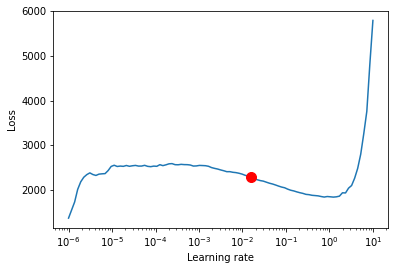

In [18]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [19]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[7] * len(time_varying_unknown_reals),  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 23.5k


In [20]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-02-03 18:21:17,209] A new study created in memory with name: no-name-a82d9e5e-849e-4d19-9bdd-da270151dd61
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-03 18:43:18,130] Trial 0 finished with value: 1066.69873046875 and parameters: {'gradient_clip_val': 0.01681694528855432, 'hidden_size': 12, 'dropout': 0.25662720672597517, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.025152138544952914}. Best is trial 0 with value: 1066.69873046875.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 

{'gradient_clip_val': 0.11509063993608082, 'hidden_size': 32, 'dropout': 0.20828090902647864, 'hidden_continuous_size': 22, 'attention_head_size': 3, 'learning_rate': 0.06469162093576221}


In [28]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [29]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0][0] for x, y in iter(val_dataloader)])

predictions = best_tft.predict(val_dataloader)
for i in predictions:
    print((actuals - i).abs().mean())

tensor(45.7801)
tensor(11138.7607)
tensor(24053.6504)
tensor(2213.4648)


In [24]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

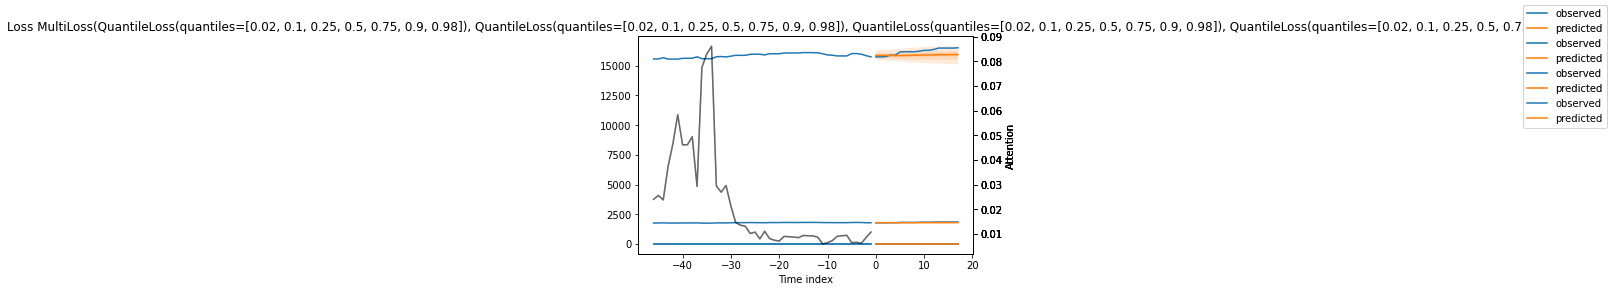

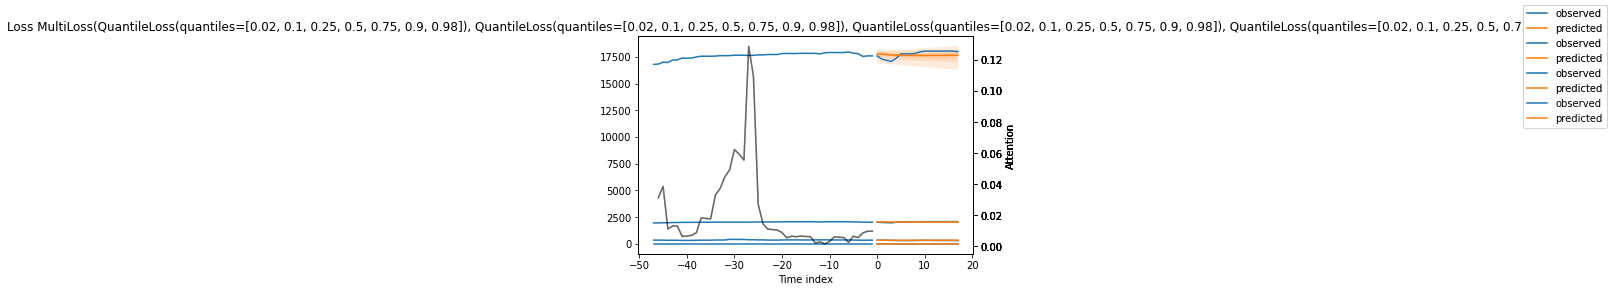

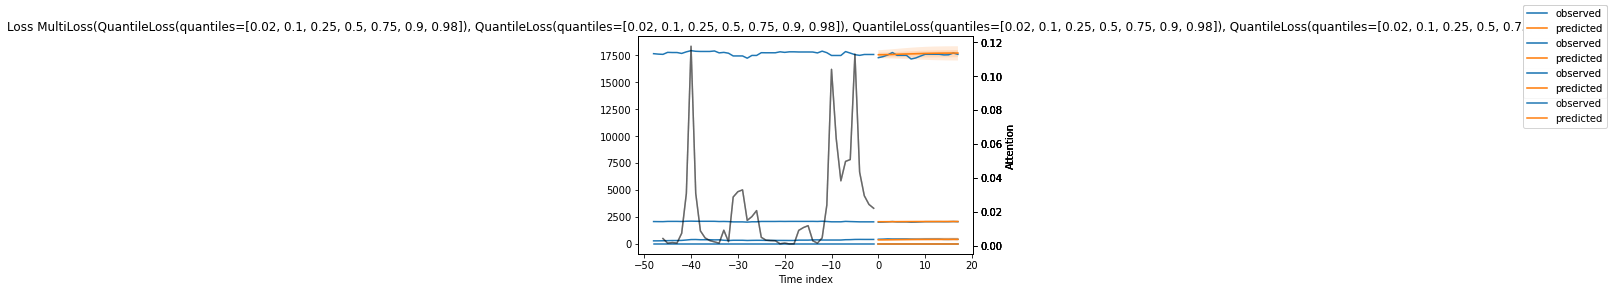

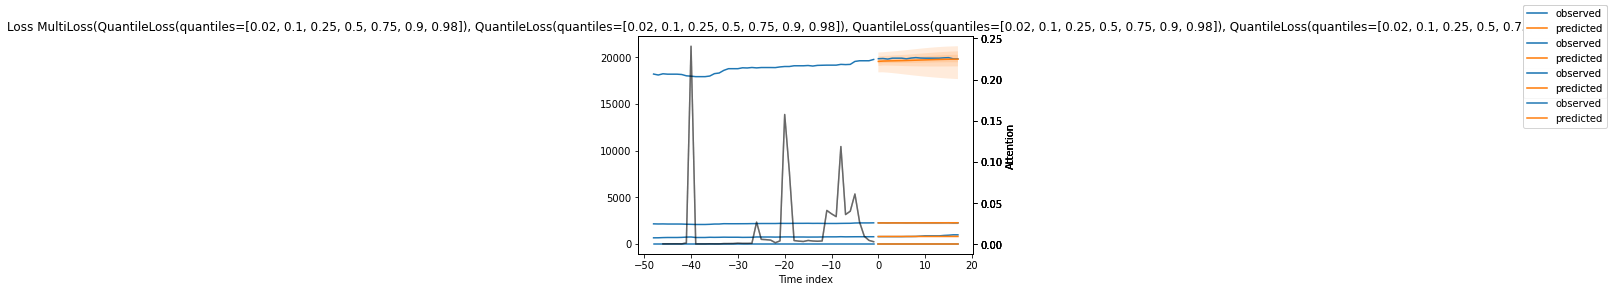

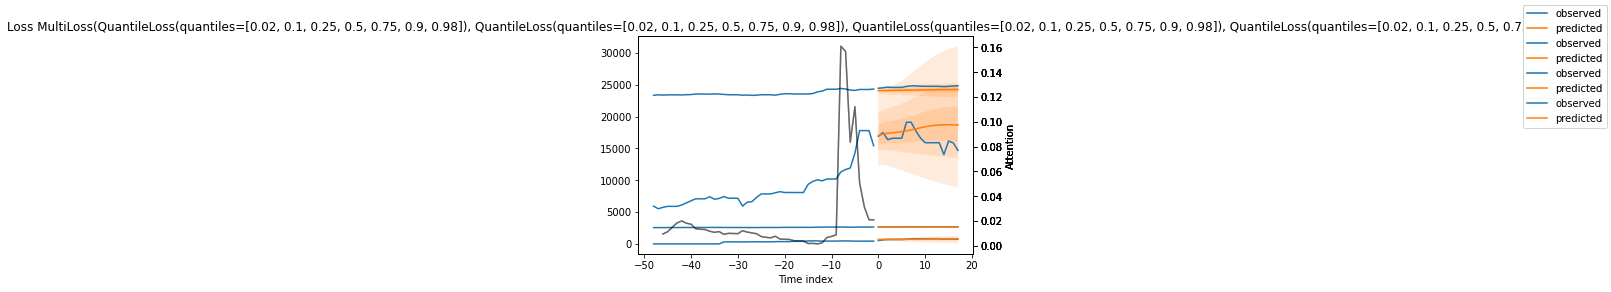

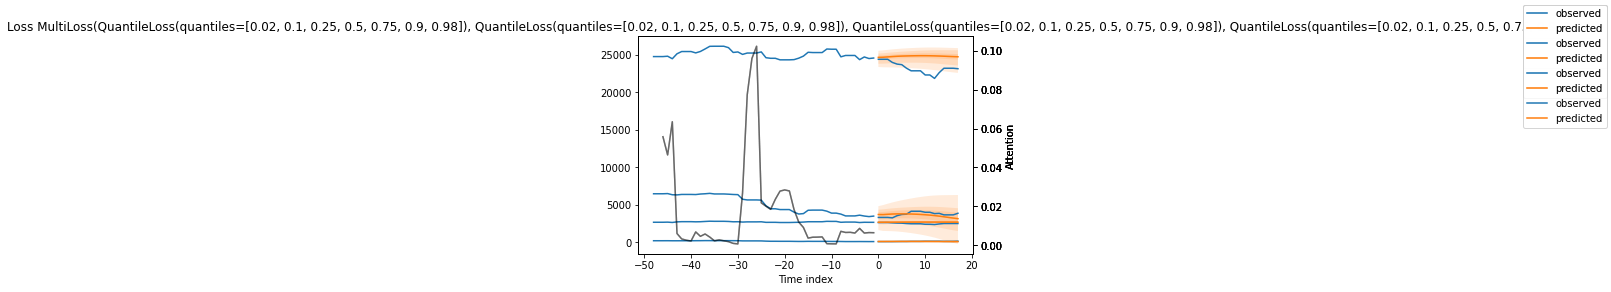

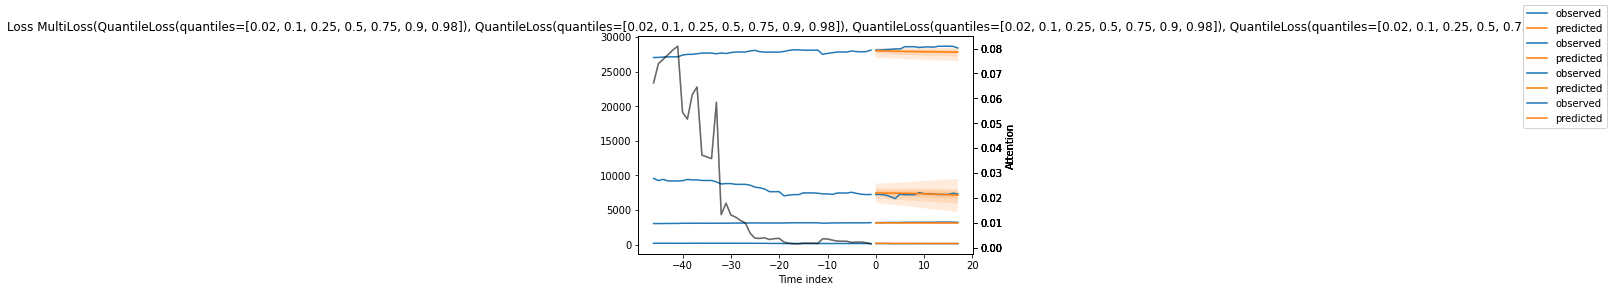

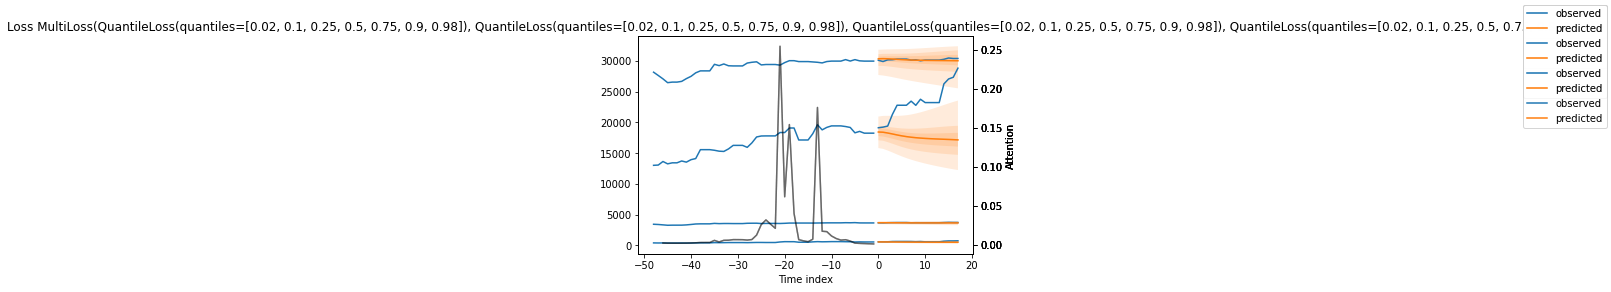

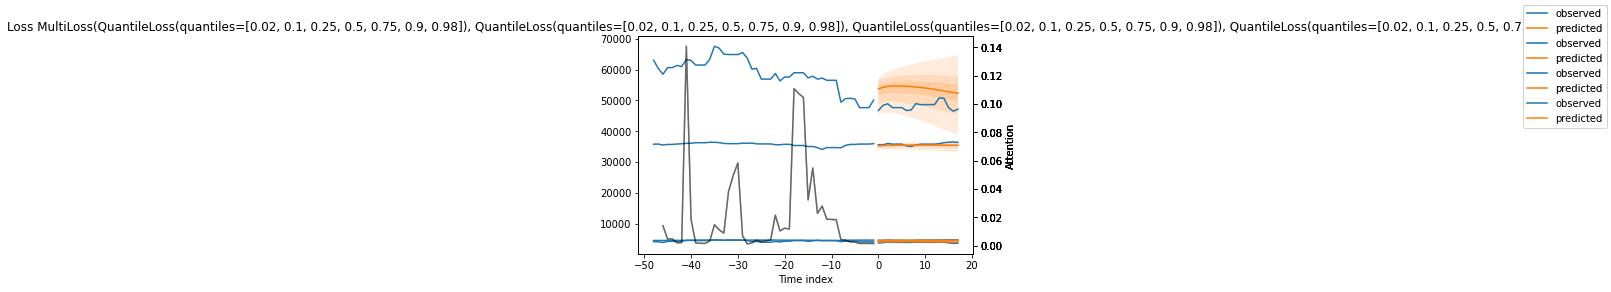

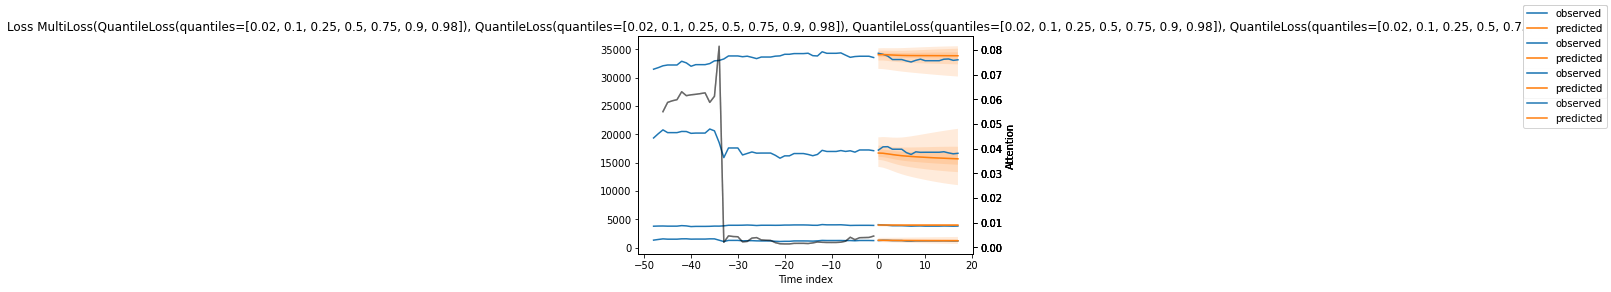

In [25]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)[0]
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [27]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
print(x.keys(), type(predictions))
predictions = predictions[0]
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale']) <class 'list'>


TypeError: ignored

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)